# A computational introduction to stochastic differential equations.

Lecture 3.

https://github.com/spdes/computational-sde-intro-lecture.

Compare Euler--Maruyama, order 1.5 strong Taylor, and TME on a linear SDE.

This notebook requires package `tme`.

In [1]:
import tme.base_jax as tme
import jax.numpy as jnp
import jax
import numpy as np
from jax import lax
from jax.config import config
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

np.random.seed(666)

In [2]:
theta = 1.

def drift(x):
    return -theta * x

b = jnp.eye(1)

def dispersion(_):
    return b

def em_m_cov(x, dt):
    """Euler--Maruyama conditional mean and covariance.
    """
    return x + drift(x) * dt, b ** 2 * dt

def tme_m_cov2(x, dt):
    """Second order TME conditional mean and covariance.

    Remark that for this linear model, the TME method gives asymptotically exact approximation of the transition for all dt.
    """
    return tme.mean_and_cov(x=x, dt=dt, drift=drift, dispersion=dispersion, order=2)

def tme_m_cov3(x, dt):
    """Third order TME conditional mean and covariance.
    """
    return tme.mean_and_cov(x=x, dt=dt, drift=drift, dispersion=dispersion, order=3)

def ito15_m_cov(x, dt):
    """Order 1.5 strong Taylor conditional mean and covariance.
    """
    gamma = b ** 2 * jnp.eye(1)
        
    es = jnp.trace(jax.hessian(drift)(x) @ gamma, axis1=1, axis2=2)
    jac_drift = jax.jacfwd(drift)(x)
    
    mean = x + drift(x) * dt + (jac_drift @ drift(x) + 0.5 * es) * (dt ** 2 / 2)
    cov = gamma * dt + jac_drift @ gamma @ jac_drift.T * (dt ** 3 / 3) + (gamma @ jac_drift.T + jac_drift @ gamma) * (dt ** 2 / 2)
    return mean, cov

def true_m_cov(x, dt):
    """True conditional mean and covariance.
    """
    return jnp.exp(-theta * dt) * x, (1 - jnp.exp(-2 * theta * dt)) / (2 * theta)

def disc_normal(m_and_cov, x0, dt, xis):
    """Simulate SDE based on Normal increments.
    """
    def scan_body(carry, elem):
        x = carry
        xi = elem

        m, cov = m_and_cov(x, dt)
        x = m + jnp.sqrt(jnp.squeeze(cov)) * xi
        return x, x

    _, sample = lax.scan(scan_body, x0, xis)
    return sample

In [3]:
# Random seed
key = jax.random.PRNGKey(666)

# Init value
x0 = jnp.zeros((1, ))

# Times
T = 100
dt = 1e-1
ts = jnp.linspace(dt, T * dt, T)

key, _ = jax.random.split(key)
xis = jax.random.normal(key, shape=(T, ))

true_sample = disc_normal(true_m_cov, x0, dt, xis)[:, 0]
sample_em = disc_normal(em_m_cov, x0, dt, xis)[:, 0]
sample_tme2 = disc_normal(tme_m_cov2, x0, dt, xis)[:, 0]
sample_tme3 = disc_normal(tme_m_cov3, x0, dt, xis)[:, 0]
sample_ito15 = disc_normal(ito15_m_cov, x0, dt, xis)[:, 0]

Plot trajectories.

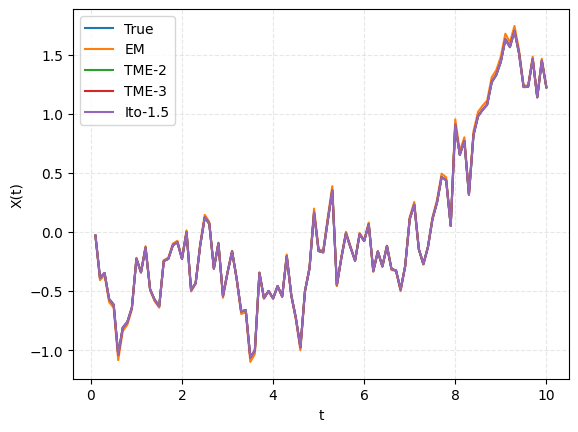

In [4]:
plt.plot(ts, true_sample, label='True')
plt.plot(ts, sample_em, label='EM')
plt.plot(ts, sample_tme2, label='TME-2')
plt.plot(ts, sample_tme3, label='TME-3')
plt.plot(ts, sample_ito15, label='Ito-1.5')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.legend()
plt.grid(linestyle='--', alpha=0.3, which='both')

Plot absolute errors with respect to the true trajectory.

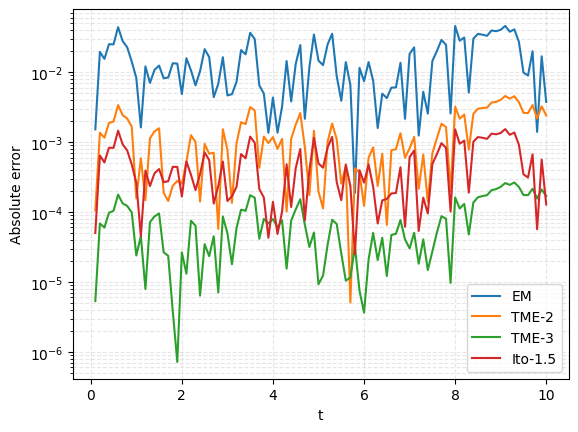

In [5]:
plt.plot(ts, jnp.abs(sample_em - true_sample), label='EM')
plt.plot(ts, jnp.abs(sample_tme2 - true_sample), label='TME-2')
plt.plot(ts, jnp.abs(sample_tme3 - true_sample), label='TME-3')
plt.plot(ts, jnp.abs(sample_ito15 - true_sample), label='Ito-1.5')
plt.yscale('log')
plt.xlabel('t')
plt.ylabel('Absolute error')
plt.legend()
plt.grid(linestyle='--', alpha=0.3, which='both')

For this model, the TME method is asymptotically exact.